# **Chapter 4: Image processing in frequency domain** 
In this notebook we introduce frequency-domain techniques for image processing, which complement the spatial-domain methods covered earlier. The focus is on using the Fourier transform to analyze, filter, and modify images based on their frequency content.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.exposure import equalize_hist

plt.rcParams['image.cmap']='gray'
plt.rcParams['figure.figsize']=[10,6]

We use the same input image as in the previous lecture. Furthermore, we perform histogram equalization to improve its contrast.

In [2]:
I = io.imread('watch.jpg')
I = equalize_hist(I)

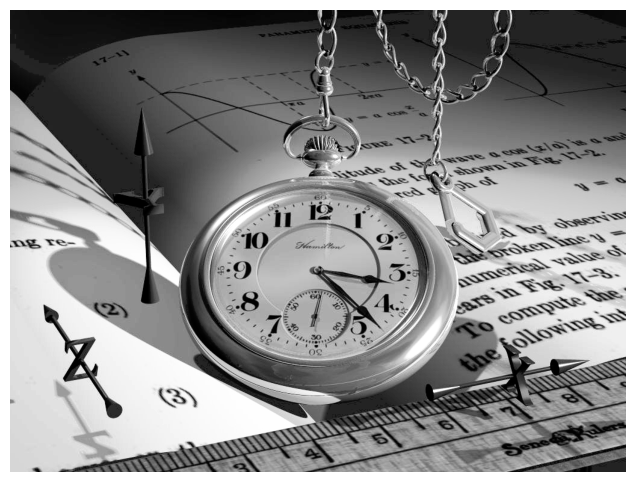

In [3]:
plt.imshow(I)
plt.axis('off');

## Discrete Fourier transform

We begin by computing the two-dimensional Discrete Fourier Transform (DFT) of an image using NumPy's `np.fft.fft2` and shifting the zero-frequency component to the center with `fftshift`. The magnitude (or amplitude) spectrum is displayed on a logarithmic scale to visualize the frequency components that make up the spatial structure of the image.

In [4]:
F = np.fft.fft2(I)

In [5]:
A = np.abs(F)

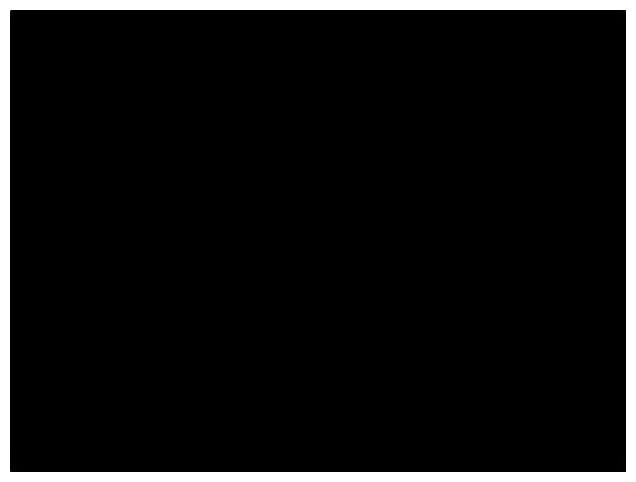

In [6]:
plt.imshow(A)
plt.axis('off');

We observe that the image is completely black and no details can be seen. Next, we shift the zero-frequency to the center of the spectrum. To make details visible, we also apply logarithmic transformation.

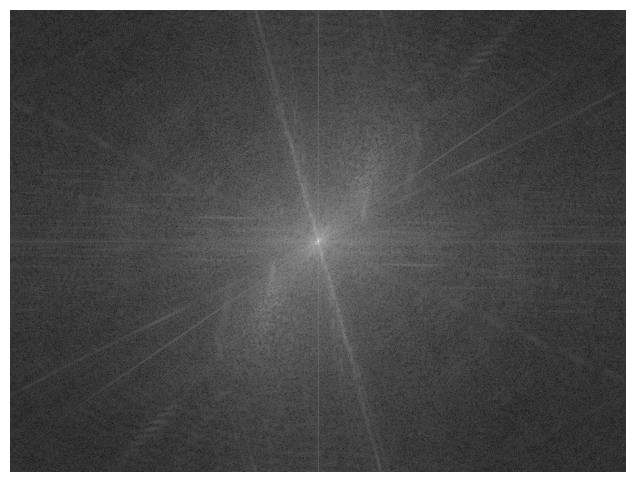

In [7]:
Az = np.fft.fftshift(A)
plt.imshow(np.log(Az+1.0))
plt.axis('off');

## Inverse Fourier Transform
Here we reconstruct the original image by applying the inverse transform `ifft2` to the frequency-domain data. Because of numerical inaccuracies, we take only the real component of the result.

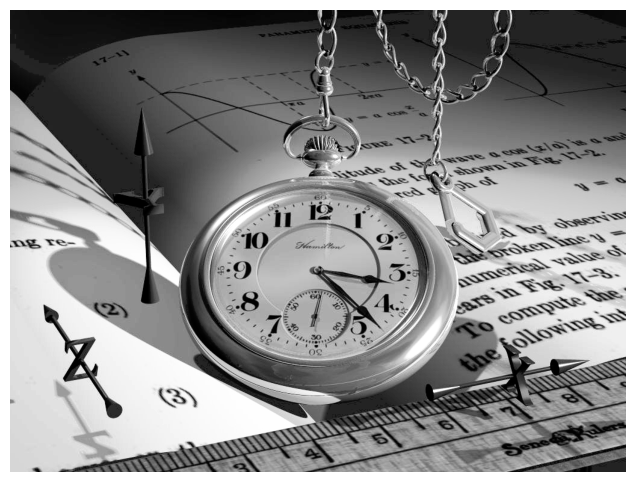

In [8]:
R = np.fft.ifft2(F).real
plt.imshow(R)
plt.axis('off');

We confirm that the Fourier transform pair preserves all the information by computing the standard deviation between the original and the reconstructed image.


In [9]:
(I-R).std()

1.7994174703210648e-16

## Fourier spectrum and phase
In this section we separate the magnitude and phase of the Fourier transform and investigate their individual roles. 

The phase spectrum is computed by dividing the Fourier transform by its magnitude.

In [10]:
P = F / (np.abs(A)+1e-10)

Note that we add a small constant to `F` to avoid division by zero. The phase spectrum is complex-valued, and if we want to illustrate it, we usually represent it as the phase angle.



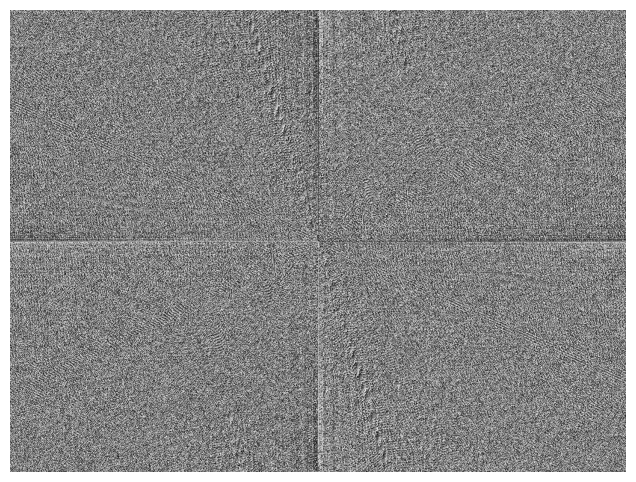

In [11]:
PA = np.angle(F)
PA = np.fft.fftshift(PA)
plt.imshow(PA)
plt.axis('off');

Then we take the inverse Fourier transform of both magnitude and phase spectra, and visualize them.

In [12]:
iA = np.fft.ifft2(A).real
iP = np.fft.ifft2(P).real

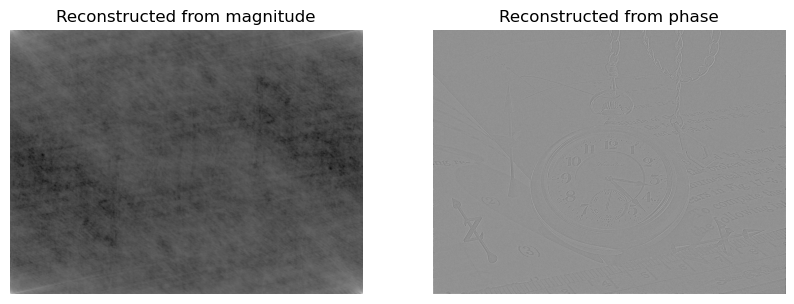

In [13]:
plt.subplot(1,2,1)
plt.imshow(np.log(iA+0.1))
plt.axis('off');
plt.title('Reconstructed from magnitude');
plt.subplot(1,2,2)
plt.imshow(iP)
plt.axis('off');
plt.title('Reconstructed from phase');

By reconstructing images using only magnitude or only phase, we can see that phase carries the essential structural information while magnitude affects overall contrast.

## Frequency domain filtering
In this section, we show how to use discrete Fourier transform (DFT) for image filtering. This is based on the convolution theorem, which states that (cyclic) convolution in spatail domain corresponds to multiplication in the frequency domain. We have two options to define the filter. It can be done 1) in spatial domain and then transfer to the frequency domain by taking its DFT, or directly in frequency domain.

### Average filtering
We start by defining an average filter (box filter) in spatial domain. Here, we need take into account that the convolution is cyclic and the center of the filter must be in the upper left corner with the coordinates (0,0). Similarly, the zero frequency of DFT is also in the upper left corner. We will use the following function to define the filter.


In [14]:
def box_filter(shape, k):
    """
    kxk average (box) filter centered at (0,0) in the periodic sense,
    same size as `shape`. Use odd k.
    """
    M, N = shape
    r = k // 2
 
    y = np.arange(M)
    x = np.arange(N)
    wy = (np.minimum(y, M - y) <= r).astype(float)
    wx = (np.minimum(x, N - x) <= r).astype(float)

    f = np.outer(wy, wx)
    f /= f.sum()
    return f

Next, we build a $7\times7$ averaging kernel.  

In [15]:
avg = box_filter(I.shape, 7)

After defining the mask in the spatial domain, we need to compute its DFT. When visualizing it, we take the magnitude component and shift the origing to the center.

In [16]:
H = np.fft.fft2(avg)

 Note that the size of the Fourier transform is the same as the image size. This can lead to the wrap-around effect.

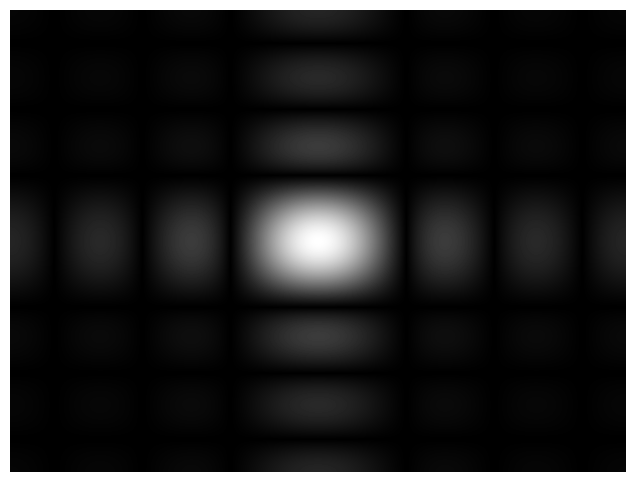

In [17]:
plt.imshow(np.abs(np.fft.fftshift(H)))
plt.axis('off');

Then, we perform the actual filtering by multiplying the DFT of the image and the filter, and take the inverse DFT. The result is shown below.

In [18]:
G = np.fft.ifft2(F*H).real

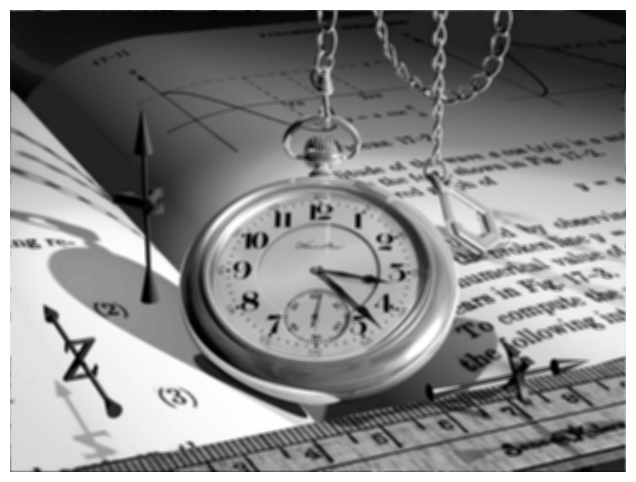

In [19]:
plt.imshow(G)
plt.axis('off');

The image is blurred as expected. Also, the wrap-around effect is visible on the image borders.

### Ideal low-pass filter

Next, apply an ideal low-pass filter that is formed directly in the frequency domain. To specify its frequency response, we need to define the vertical and horizontal frequency variables as vectors $u_0$ and $v_0$, and make a 2-D grid, which gives the frequency variables $u$ and $v$ for each 2D frequency coefficient.

We form frequency grids $(u,v)$ with `fftfreq`, compute the radius $D=\sqrt{u^2+v^2}$, and create a circular passband $H(D)=\mathbf{1}\{D\le D_0\}$. After visualizing the filter and its cross-section, we apply it ($G=\mathcal{F}^{-1}\{HF\}$) and observe smoothing along with ringing due to the sharp cutoff.

In [20]:
m,n = I.shape

In [21]:
u0 = np.fft.fftfreq(n)
v0 = np.fft.fftfreq(m)

In [22]:
print(u0)

[ 0.          0.00097656  0.00195312 ... -0.00292969 -0.00195312
 -0.00097656]


In [23]:
u,v = np.meshgrid(u0,v0)

Using the corresponding frequency variables, we create the ideal low pass filter based on the distance from the zero-frequency. We set all coefficient to one that are closer than the threshold $D_0 = 0.1$ to the origin. The remaining coefficients are set to zeros.

In [24]:
D = np.sqrt(u**2 + v**2)
D0 = 0.1

In [25]:
HI = D <= D0

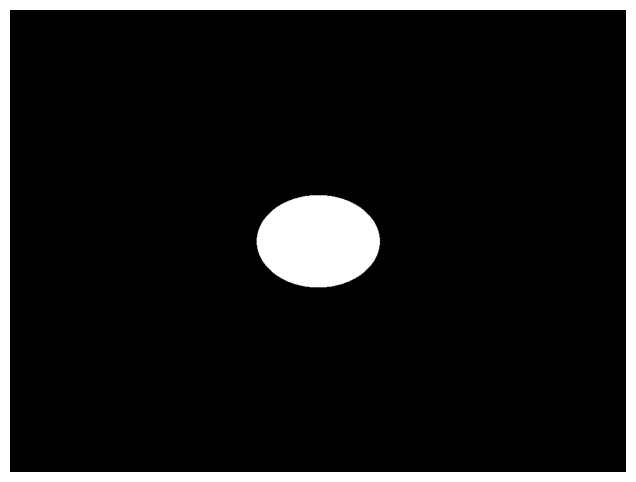

In [26]:
plt.imshow(np.fft.fftshift(HI))
plt.axis('off');

Here is also a visualization of the filter cross-section.

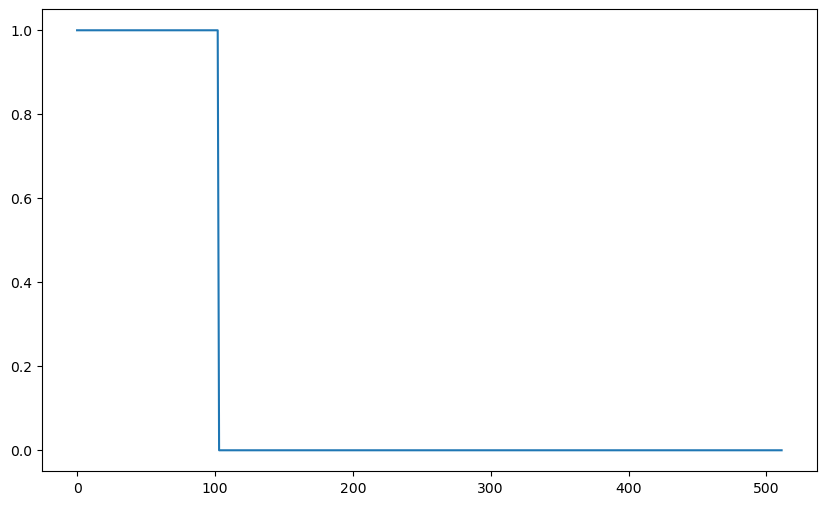

In [27]:
plt.plot(HI[0,:n//2])

Then, we perform the actual filtering, and illustrate the result, which shows substantial ringing effect.

In [28]:
G = np.fft.ifft2(F*HI).real.clip(0,255)

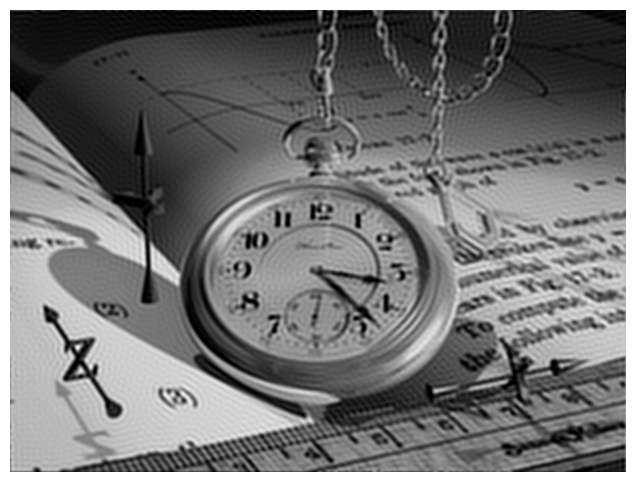

In [29]:
plt.imshow(G)
plt.axis('off');

### Butterworth low-pass filter
We replace the hard cutoff with a Butterworth response $H(D)=\frac{1}{1+(D/D_0)^n}$ (here $n=4$) to obtain a smoother transition band. Filtering with this $H$ reduces ringing compared to the ideal LPF while still attenuating high frequencies.

In [30]:
HB = 1/(1+(D/D0)**4)

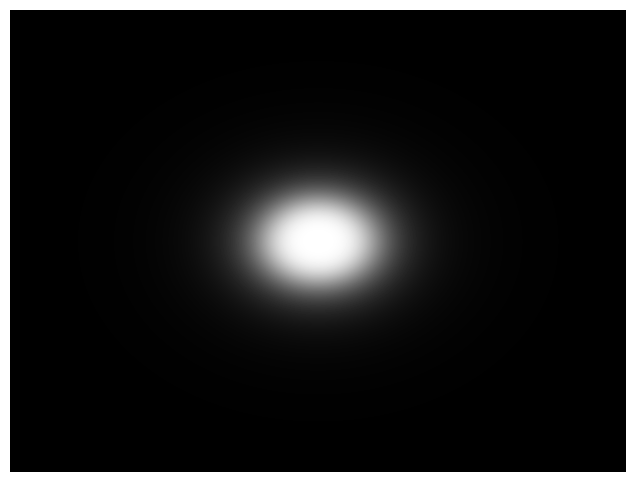

In [31]:
plt.imshow(np.fft.fftshift(HB))
plt.axis('off');

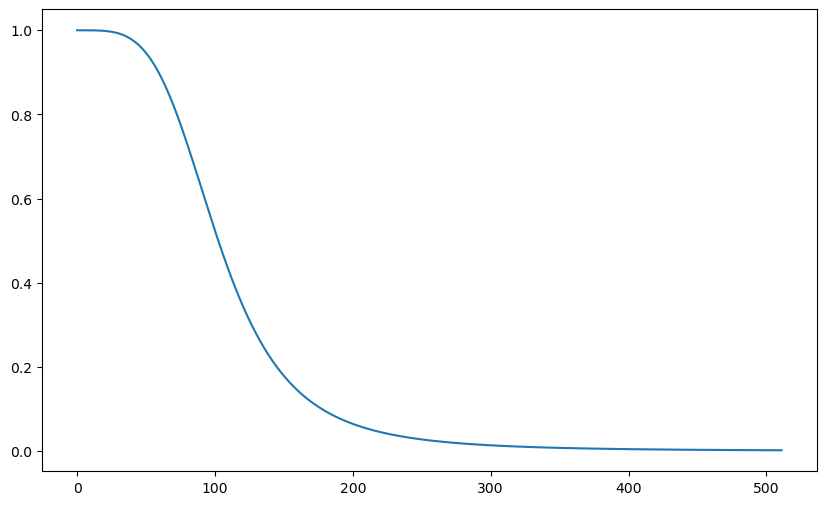

In [32]:
plt.plot(HB[0,:n//2])

Then, we do the filtering and show the result.

In [33]:
G = np.fft.ifft2(HB*F).real

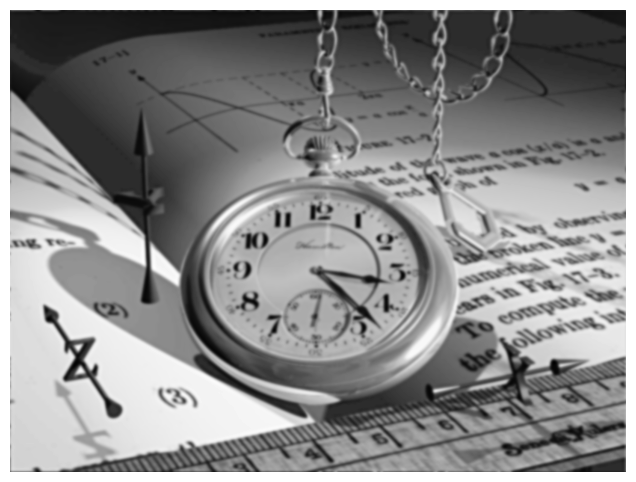

In [34]:
plt.imshow(G)
plt.axis('off');

### Gaussian low-pass filter
We use a Gaussian low-pass $H(D)=\exp\!\big(-D^2/(2D_0^2)\big)$ and visualize both its 2D shape and a 1D slice. Applying it produces a smoothly blurred image with minimal ringing thanks to the infinitely smooth frequency roll-off.


In [35]:
HG = np.exp(-D**2/2/D0**2)

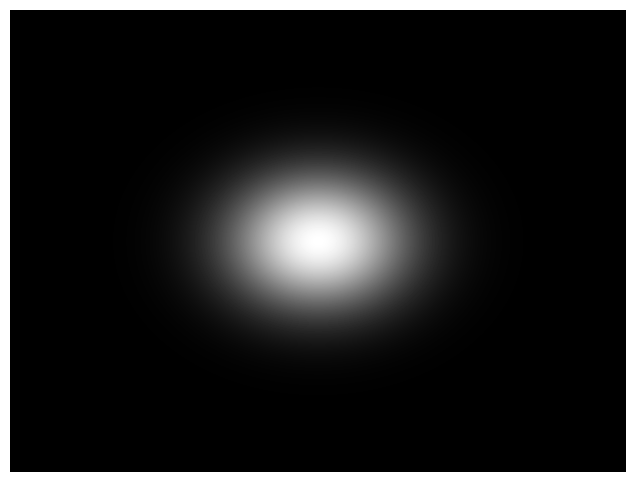

In [36]:
plt.imshow(np.fft.fftshift(HG))
plt.axis('off');

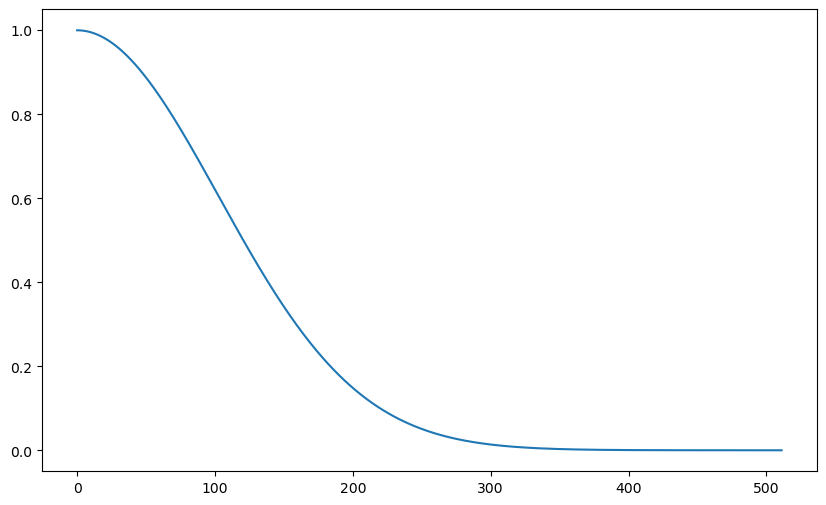

In [37]:
plt.plot(HG[0,:n//2])

In [38]:
G = np.fft.ifft2(HG*F).real

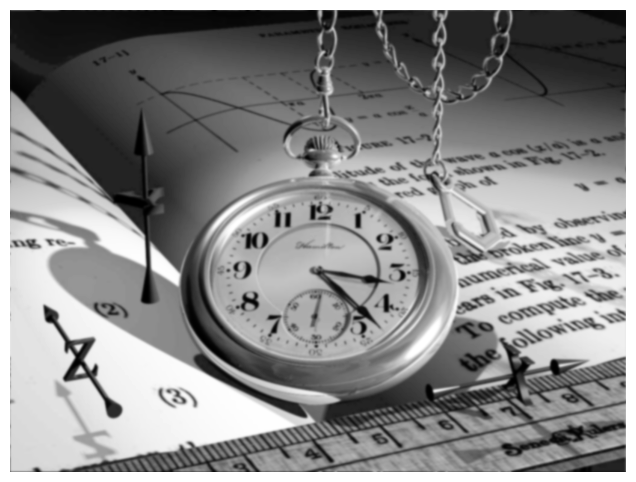

In [39]:
plt.imshow(G)
plt.axis('off');

### Gaussian high-pass filter

High-pass filters can be implemented by subtracting the corresponding low-pass filters from 1. We construct a Gaussian high-pass via $H_{\mathrm{HP}}(D)=1-H_{\mathrm{LP}}(D)$ to keep edges and fine details while suppressing low-frequency background. The filtered result emphasizes high-frequency structure, making boundaries and textures stand out.


In [40]:
HGh = 1 - HG

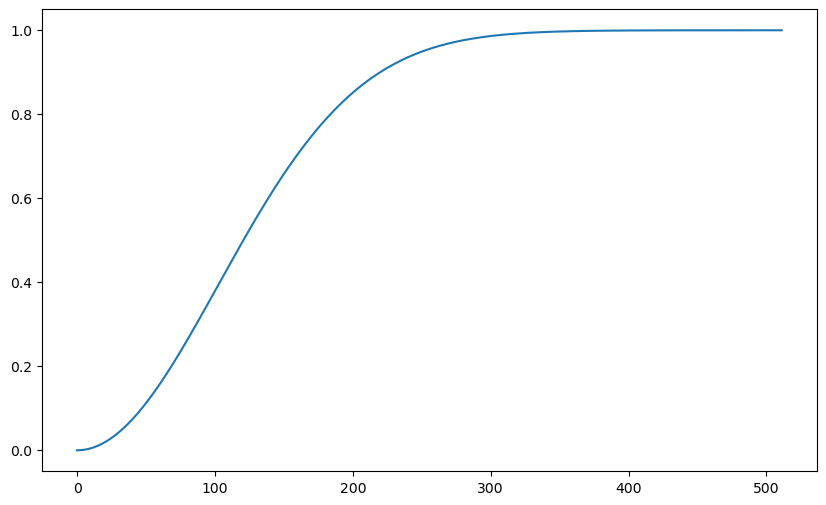

In [41]:
plt.plot(HGh[0,:n//2])

In [42]:
G = np.fft.ifft2(HGh*F).real

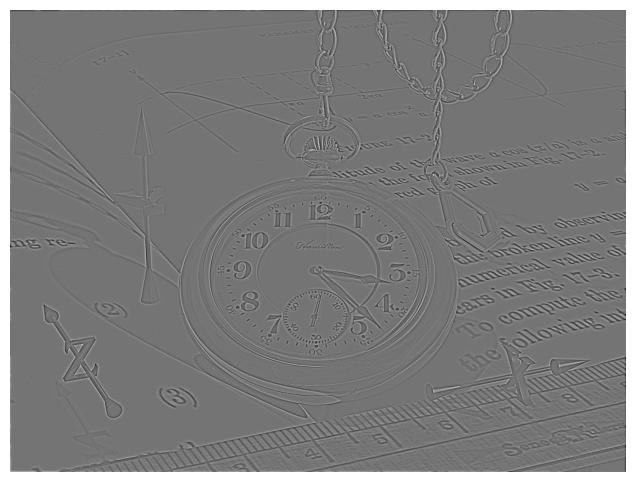

In [43]:
plt.imshow(G)
plt.axis('off');

### Laplacian operator
We implement the Laplacian in the frequency domain using the response $L(u,v)=-(u^2+v^2)$ and apply it to the spectrum to obtain a second-derivative image after inverse DFT. The outcome highlights rapid intensity changes (edges) while large uniform regions tend toward gray.

In [44]:
L = -(u**2+v**2)

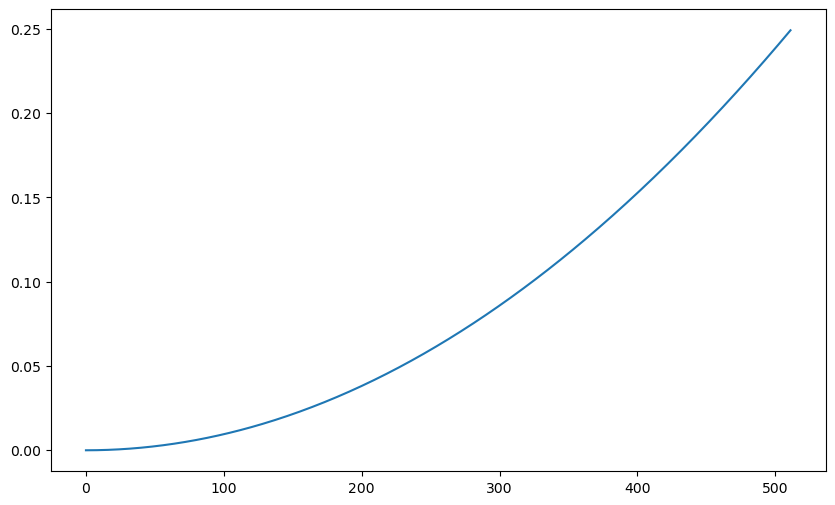

In [45]:
plt.plot(abs(L[0,:n//2]))

In [46]:
LI = np.fft.ifft2(L*F).real

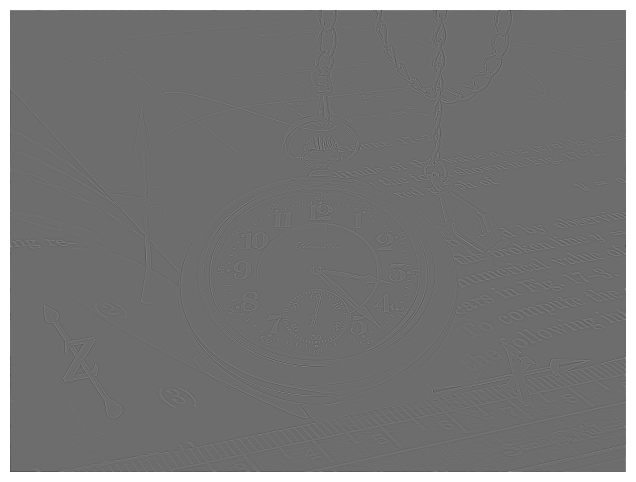

In [47]:
plt.imshow(LI)
plt.axis('off');

### Homomorphic filter
Homomorphic filter can be used to improve the contrast of the image and deal with non-uniform lighting. Next, we define the filter frequency response as $H_{\mathrm{HP}}=\big(1-\exp(-D^2/(2D_0^2))\big)\cdot 0.7+0.4$, which attenuates the frequency components that are close to zero-frequency, while amplifying the remaining high frequencies.


In [48]:
D0 = 0.005
HGh = 1 - np.exp(-D**2/2/D0**2)
HGh = HGh*0.7 + 0.4

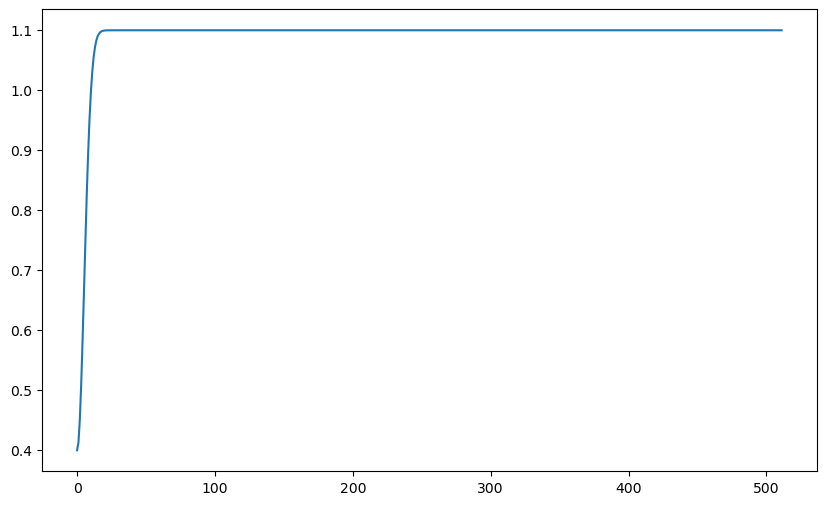

In [49]:
plt.plot(HGh[0,:n//2])

The filtering is performed to the logarithmic version of the image $F_L=\mathcal{F}\{\log I\}$. After filtering, exponent function is applied to compensate for the logarithm so that $I_H=\exp\big(\mathcal{F}^{-1}\{H_{\mathrm{HP}}F_L\}\big)$. We can see from the result that the dark details of the background in the original image are now much brighter.

In [50]:
FL = np.fft.fft2(np.log(I))

In [51]:
GL = np.fft.ifft2(FL*HGh).real

In [52]:
IH = (np.exp(GL)).clip(0,1)

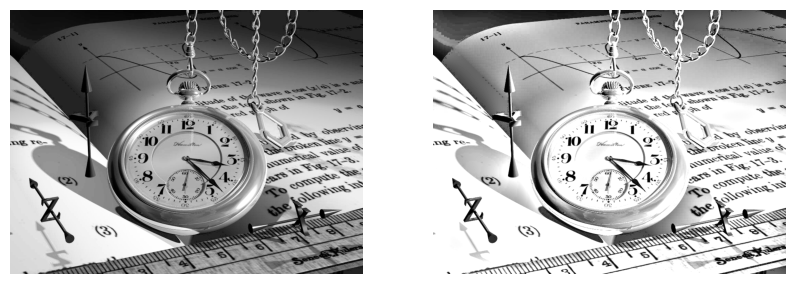

In [53]:
plt.subplot(1,2,1)
plt.imshow(I)
plt.axis('off');
plt.subplot(1,2,2)
plt.imshow(IH)
plt.axis('off');